In [1]:
import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display

import numpy as np
import pandas as pd
from scipy.stats import uniform, randint

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, TimeSeriesSplit,
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (Dense, LSTM, Dropout, Embedding, Reshape, Concatenate,
                                     RepeatVector, Bidirectional, Layer, Add, LayerNormalization,
                                     Multiply, Lambda, MultiHeadAttention, GlobalAveragePooling1D,
                                     BatchNormalization, Conv1D, Activation, ReLU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import register_keras_serializable
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch, Objective
from keras_tuner.tuners import BayesianOptimization

from tcn import TCN
import pickle


In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,TOTALCREDITAMOUNT,TOTALDEBITAMOUNT
0,31/03/2025,75,75,HOMAGAMA,COLOMBO,WESTERN,6.841287,80.002912,31,1665824.00,945600.00,720224.0
1,31/03/2025,214,214,URAGASMANHANDIYA,GALLE,SOUTHERN,6.349000,80.097864,16,1472377.00,1463381.00,8996.0
2,31/03/2025,11,11,KURUNEGALA,KURUNEGALA,NORTH WESTERN,7.489602,80.365024,16,1091657.00,998000.00,93657.0
3,31/03/2025,32,32,KANDANA,GAMPAHA,WESTERN,7.048289,79.899634,27,5768985.73,4436876.73,1332109.0
4,31/03/2025,66,66,KALAWANCHIKUDY,BATTICALOA,EASTERN,7.517505,81.786116,19,592609.24,568370.24,24239.0


# Feature Engineering

In [4]:
# Convert TXNDATE to datetime format
df['TXNDATE'] = pd.to_datetime(df['TXNDATE'], dayfirst=True)  

In [5]:
# Sort in ascending order
df = df.sort_values(by=['BRANCHID', 'TXNDATE']).reset_index(drop=True)

In [6]:
# Day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['TXNDATE'].dt.dayofweek

# Is weekend? (Saturday = 5, Sunday = 6)
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Month
df['Month'] = df['TXNDATE'].dt.month

# Year
df['Year'] = df['TXNDATE'].dt.year

In [7]:
# View new features
df[['TXNDATE', 'DayOfWeek', 'IsWeekend', 'Month', 'Year']].head(500)

,TXNDATE,DayOfWeek,IsWeekend,Month,Year
0,2022-04-01,4,0,4,2022
1,2022-04-02,5,1,4,2022
2,2022-04-04,0,0,4,2022
3,2022-04-05,1,0,4,2022
4,2022-04-06,2,0,4,2022
...,...,...,...,...,...
495,2023-12-01,4,0,12,2023
496,2023-12-02,5,1,12,2023
497,2023-12-04,0,0,12,2023
498,2023-12-05,1,0,12,2023


In [8]:
# Load holiday list from Excel
holidays_df = pd.read_csv("holidays.csv")

In [9]:
# Convert 'DATE' column to datetime format
holidays_df['DATE'] = pd.to_datetime(holidays_df['DATE'])

In [10]:
# Create a holiday list as a set for faster lookup
holiday_dates = set(holidays_df['DATE'])

# Create 'IsHoliday' column: 1 if date is a holiday, else 0
df['IsHoliday'] = df['TXNDATE'].isin(holiday_dates).astype(int)

In [11]:
df[['TXNDATE', 'IsHoliday']].head(1000)

,TXNDATE,IsHoliday
0,2022-04-01,0
1,2022-04-02,0
2,2022-04-04,0
3,2022-04-05,0
4,2022-04-06,0
...,...,...
995,2022-08-13,0
996,2022-08-15,0
997,2022-08-16,0
998,2022-08-17,0


In [12]:
# Create 'IsNonWorkingDay' column: 1 if date is a NonWorking Day, else 0
df['IsNonWorkingDay'] = ((df['IsWeekend'] == 1) | (df['IsHoliday'] == 1)).astype(int)

In [13]:
df.head(500)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,TOTALCREDITAMOUNT,TOTALDEBITAMOUNT,DayOfWeek,IsWeekend,Month,Year,IsHoliday,IsNonWorkingDay
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,3119590.86,2787606.69,4,0,4,2022,0,0
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,44100.00,0.00,5,1,4,2022,0,1
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,1953410.00,1357000.00,0,0,4,2022,0,0
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,15275573.75,10037500.00,1,0,4,2022,0,0
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,5638501.70,5885785.93,2,0,4,2022,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-12-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,43,22944753.25,18424680.25,4520073.00,4,0,12,2023,0,0
496,2023-12-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,5,183150.00,183000.00,150.00,5,1,12,2023,0,1
497,2023-12-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,50,10300308.26,8278492.34,2021815.92,0,0,12,2023,0,0
498,2023-12-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,31,13677814.00,11421350.00,2256464.00,1,0,12,2023,0,0


### Lag Features (Past Values)

In [14]:
df['Lag1_Credit'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].shift(1)
df['Lag1_Debit'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].shift(1)
df['Lag1_Customers'] = df.groupby('BRANCHID')['CUSTOMER'].shift(1)

In [15]:
for lag in [1,2, 3, 7, 14]:
    df[f'Lag{lag}_Credit'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].shift(lag)
    df[f'Lag{lag}_Debit'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].shift(lag)
    df[f'Lag{lag}_Customers'] = df.groupby('BRANCHID')['CUSTOMER'].shift(lag)

In [16]:
df[['TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'CUSTOMER',
    'Lag1_Credit', 'Lag1_Debit', 'Lag1_Customers', 
    'Lag2_Credit', 'Lag2_Debit', 'Lag2_Customers' ,
    'Lag3_Credit', 'Lag3_Debit', 'Lag3_Customers' ,
    'Lag7_Credit', 'Lag7_Debit', 'Lag7_Customers',
    'Lag14_Credit', 'Lag14_Debit', 'Lag14_Customers'
   ]].head(20)

,TOTALCREDITAMOUNT,TOTALDEBITAMOUNT,CUSTOMER,Lag1_Credit,Lag1_Debit,Lag1_Customers,Lag2_Credit,Lag2_Debit,Lag2_Customers,Lag3_Credit,Lag3_Debit,Lag3_Customers,Lag7_Credit,Lag7_Debit,Lag7_Customers,Lag14_Credit,Lag14_Debit,Lag14_Customers
0,3119590.86,2787606.69,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44100.00,0.00,3,3119590.86,2787606.69,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1953410.00,1357000.00,26,44100.00,0.00,3.0,3119590.86,2787606.69,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15275573.75,10037500.00,30,1953410.00,1357000.00,26.0,44100.00,0.00,3.0,3119590.86,2787606.69,39.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5638501.70,5885785.93,29,15275573.75,10037500.00,30.0,1953410.00,1357000.00,26.0,44100.00,0.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1440080.00,9268215.18,39,5638501.70,5885785.93,29.0,15275573.75,10037500.00,30.0,1953410.00,1357000.00,26.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2017655.00,46580149.98,72,1440080.00,9268215.18,39.0,5638501.70,5885785.93,29.0,15275573.75,10037500.00,30.0,NaN,NaN,NaN,NaN,NaN,NaN
7,64700.00,1015000.00,11,2017655.00,46580149.98,72.0,1440080.00,9268215.18,39.0,5638501.70,5885785.93,29.0,3119590.86,2787606.69,39.0,NaN,NaN,NaN
8,5640132.06,6495644.34,52,64700.00,1015000.00,11.0,2017655.00,46580149.98,72.0,1440080.00,9268215.18,39.0,44100.00,0.00,3.0,NaN,NaN,NaN
9,1840495.53,15660677.58,66,5640132.06,6495644.34,52.0,64700.00,1015000.00,11.0,2017655.00,46580149.98,72.0,1953410.00,1357000.00,26.0,NaN,NaN,NaN


### Rolling Statistics (Short-term & Long-term Trends)

In [17]:
# Rolling features for debits
df['Rolling7_DebitMean'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df['Rolling7_DebitStd'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).std())

# Rolling features for customers
df['Rolling7_CustomersMean'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df['Rolling7_CustomersStd'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(window=7).std())

# Rolling features for credit
df['Rolling7_CreditMean'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df['Rolling7_CreditStd'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(window=7).std())

In [18]:
df.head(10)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,...,Lag7_Customers,Lag14_Credit,Lag14_Debit,Lag14_Customers,Rolling7_DebitMean,Rolling7_DebitStd,Rolling7_CustomersMean,Rolling7_CustomersStd,Rolling7_CreditMean,Rolling7_CreditStd
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-04-07,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,10708295.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2022-04-08,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,72,48597804.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-04-09,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,11,1079700.00,...,39.0,NaN,NaN,NaN,1.084518e+07,1.621363e+07,34.0,20.655911,4.212702e+06,5.173687e+06
8,2022-04-11,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,52,12135776.40,...,3.0,NaN,NaN,NaN,1.059195e+07,1.637350e+07,30.0,22.181073,3.776289e+06,5.404937e+06
9,2022-04-12,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,66,17501173.11,...,26.0,NaN,NaN,NaN,1.151990e+07,1.584883e+07,37.0,19.849433,4.575722e+06,5.169640e+06


In [19]:
# 3-day rolling averages
df['Rolling3_CreditMean'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Rolling3_DebitMean'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Rolling3_CustomersMean'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(3).mean())

# 3-day rolling standard deviation
df['Rolling3_CustomersStd'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(3).std())
df['Rolling3_CreditStd'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).std())
df['Rolling3_DebitStd'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(3).std())

In [20]:
# 30-day rolling averages
df['Rolling30_CreditMean'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).mean())
df['Rolling30_DebitMean'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).mean())
df['Rolling30_CustomersMean'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(30).mean())

# 30-day rolling standard deviation
df['Rolling30_CustomersStd'] = df.groupby('BRANCHID')['CUSTOMER'].transform(lambda x: x.shift(1).rolling(30).std())
df['Rolling30_CreditStd'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).std())
df['Rolling30_DebitStd'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].transform(lambda x: x.shift(1).rolling(30).std())

### Combined Features (Lag & Rolling)

In [21]:
target_cols = ['Credit', 'Debit', 'Customers']
rolling_windows = [3, 7]

for target in target_cols:
    lag_col = f'Lag1_{target}'
    
    for window in rolling_windows:
        mean_col = f'Rolling{window}_{target}Mean'
        std_col = f'Rolling{window}_{target}Std'
        
        # Difference from mean
        df[f'{lag_col}_vs_Mean{window}'] = df[lag_col] - df[mean_col]
        
        # Ratio to mean (avoid division by 0)
        df[f'{lag_col}_Ratio_Mean{window}'] = df[lag_col] / (df[mean_col] + 1e-6)
        
        # Z-score (standardized deviation)
        df[f'{lag_col}_ZScore{window}'] = (df[lag_col] - df[mean_col]) / (df[std_col] + 1e-6)

In [22]:
df.head(100)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,...,Lag1_Debit_ZScore3,Lag1_Debit_vs_Mean7,Lag1_Debit_Ratio_Mean7,Lag1_Debit_ZScore7,Lag1_Customers_vs_Mean3,Lag1_Customers_Ratio_Mean3,Lag1_Customers_ZScore3,Lag1_Customers_vs_Mean7,Lag1_Customers_Ratio_Mean7,Lag1_Customers_ZScore7
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,...,-0.017601,NaN,NaN,NaN,3.333333,1.147059,0.182849,NaN,NaN,NaN
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,...,1.145703,NaN,NaN,NaN,10.333333,1.525424,0.709139,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2022-07-30,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,8,905645.02,...,-0.028263,-1.551549e+06,0.635063,-0.270265,8.000000,1.266667,1.142857,8.571429,1.291262,0.656847
96,2022-07-31,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,469800.00,...,-1.104915,-3.507263e+06,0.078797,-0.591054,-16.333333,0.328767,-1.076208,-17.714286,0.311111,-1.175122
97,2022-08-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3985750.00,...,-0.675737,-3.807263e+06,0.000000,-0.641611,-13.333333,0.183673,-0.704361,-22.714286,0.116667,-1.506810
98,2022-08-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,12910647.61,...,1.150544,-8.854557e+05,0.783468,-0.151694,13.666667,2.108108,1.129772,2.285714,1.096385,0.166450


In [23]:
# Sort data by date per branch
df = df.sort_values(['BRANCHID', 'TXNDATE'], ascending=[True, True])

### Ratios & Deltas

In [24]:
# How much of the credit was withdrawn
df['Debit_to_Credit_Ratio'] = df['TOTALDEBITAMOUNT'] / (df['TOTALCREDITAMOUNT'] + 1)

In [25]:
#Cash in or out per customers visited
df['CashOut_Per_Customer'] = df['TOTALDEBITAMOUNT'] / (df['CUSTOMER'] + 1)
df['CashIn_Per_Customer'] = df['TOTALCREDITAMOUNT'] / (df['CUSTOMER'] + 1)

In [26]:
#  Net Cash Flow (Shows overall surplus or deficit of cash that day) - Response variable
df['NetCashFlow'] = df['TOTALCREDITAMOUNT'] - df['TOTALDEBITAMOUNT']

In [27]:
# Net Cash Flow per Customer
df['NetCashFlow_Per_Customer'] = df['NetCashFlow'] / (df['CUSTOMER'] + 1)

In [28]:
# Day-over-Day Deltas
df['Delta_Debit'] = df.groupby('BRANCHID')['TOTALDEBITAMOUNT'].diff(1)
df['Delta_Credit'] = df.groupby('BRANCHID')['TOTALCREDITAMOUNT'].diff(1)
df['Delta_Customers'] = df.groupby('BRANCHID')['CUSTOMER'].diff(1)

In [29]:
# Rolling Delta vs Mean (Z-score type feature) : helps to detect spikes or drops
df['Debit_ZScore'] = (df['TOTALDEBITAMOUNT'] - df['Rolling7_DebitMean']) / (df['Rolling7_DebitStd'] + 1)
df['Credit_ZScore'] = (df['TOTALCREDITAMOUNT'] - df['Rolling7_CreditMean']) / (df['Rolling7_CreditStd'] + 1)

### Time Positioning Flags

In [30]:
df['IsMonthStart'] = df['TXNDATE'].dt.is_month_start.astype(int)
df['IsMonthEnd'] = df['TXNDATE'].dt.is_month_end.astype(int)

In [31]:
# First and last 5 days of the month

# Ensure TXNDATE is datetime
df['TXNDATE'] = pd.to_datetime(df['TXNDATE'])

# Day of the month
df['DayOfMonth'] = df['TXNDATE'].dt.day

# Number of days in the month
df['DaysInMonth'] = df['TXNDATE'].dt.days_in_month

# Is it in the first 5 days of the month?
df['IsFirst5Days'] = (df['DayOfMonth'] <= 5).astype(int)

# Is it in the last 5 days of the month?
df['IsLast5Days'] = (df['DayOfMonth'] > (df['DaysInMonth'] - 5)).astype(int)

In [32]:
# Load the inflation dataset
inflation = pd.read_csv("inflation.csv")

In [33]:
# Make inflation 'Month' is zero-padded to match datetime format
inflation['Month'] = inflation['Month'].astype(int)
inflation['Year'] = inflation['Year'].astype(int)

In [34]:
# Merge the inflation data into main dataframe
df = df.merge(inflation, on=['Year', 'Month'], how='left')

In [35]:
# Check for missing inflation values
missing_inflation = df[df['NCPI_Index'].isna()]
print(f"Rows with missing inflation data: {len(missing_inflation)}")

Rows with missing inflation data: 0


In [36]:
df.head(500)

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,...,Credit_ZScore,IsMonthStart,IsMonthEnd,DayOfMonth,DaysInMonth,IsFirst5Days,IsLast5Days,NCPI_Index,NCPI-Headline_Inflation,NCPI-Core_Inflation
0,2022-04-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,39,5907197.55,...,NaN,1,0,1,30,1,0,151.7,33.8,27.9
1,2022-04-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,3,44100.00,...,NaN,0,0,2,30,1,0,151.7,33.8,27.9
2,2022-04-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,26,3310410.00,...,NaN,0,0,4,30,1,0,151.7,33.8,27.9
3,2022-04-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,30,25313073.75,...,NaN,0,0,5,30,1,0,151.7,33.8,27.9
4,2022-04-06,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,29,11524287.63,...,NaN,0,0,6,30,0,0,151.7,33.8,27.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-12-01,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,43,22944753.25,...,-0.155821,1,0,1,31,1,0,208.8,4.2,0.9
496,2023-12-02,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,5,183150.00,...,-0.629944,0,0,2,31,1,0,208.8,4.2,0.9
497,2023-12-04,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,50,10300308.26,...,-0.443404,0,0,4,31,1,0,208.8,4.2,0.9
498,2023-12-05,1,1,HEAD OFFICE,COLOMBO,WESTERN,6.902243,79.86391,31,13677814.00,...,-0.405258,0,0,5,31,1,0,208.8,4.2,0.9


# Preprocessing

### 1. Date Parsing & Sorting

In [37]:
df["TXNDATE"] = pd.to_datetime(df["TXNDATE"], format="%d/%m/%Y")
df.sort_values(["BRANCHID", "TXNDATE"], inplace=True)

### 2. Categorical Encoding

In [38]:
df_ = df.copy()
for col in ["BRANCH", "DISTRICT", "PROVINCE", "CODE"]:
    df_[col] = LabelEncoder().fit_transform(df[col])

### 3. Handle Missing Values 

In [39]:
df.shape

(172192, 88)

In [40]:
df_.shape

(172192, 88)

In [41]:
rolling_lag_cols = [
    "Lag1_Credit",	"Lag1_Debit",	"Lag1_Customers",	"Lag2_Credit",	"Lag2_Debit",	"Lag2_Customers",	
    "Lag3_Credit",	"Lag3_Debit",	"Lag3_Customers",	"Lag7_Credit",	"Lag7_Debit",	"Lag7_Customers",	
    "Lag14_Credit",	"Lag14_Debit",	"Lag14_Customers",
    "Rolling7_DebitMean", "Rolling7_DebitStd", "Rolling7_CustomersMean", "Rolling7_CustomersStd", "Rolling7_CreditMean", "Rolling7_CreditStd",
    "Rolling3_CreditMean", "Rolling3_DebitMean", "Rolling3_CustomersMean", "Rolling3_CustomersStd", "Rolling3_CreditStd", "Rolling3_DebitStd",
    "Rolling30_CreditMean", "Rolling30_DebitMean", "Rolling30_CustomersMean", "Rolling30_CustomersStd", "Rolling30_CreditStd", "Rolling30_DebitStd",
    "Lag1_Credit_vs_Mean3",	"Lag1_Credit_Ratio_Mean3",	"Lag1_Credit_ZScore3",	"Lag1_Credit_vs_Mean7",	"Lag1_Credit_Ratio_Mean7",	
    "Lag1_Credit_ZScore7",	"Lag1_Debit_vs_Mean3",	"Lag1_Debit_Ratio_Mean3",	"Lag1_Debit_ZScore3",	"Lag1_Debit_vs_Mean7",	"Lag1_Debit_Ratio_Mean7",	
    "Lag1_Debit_ZScore7",	"Lag1_Customers_vs_Mean3",	"Lag1_Customers_Ratio_Mean3",	"Lag1_Customers_ZScore3",	"Lag1_Customers_vs_Mean7",	
    "Lag1_Customers_Ratio_Mean7",	"Lag1_Customers_ZScore7", "Delta_Debit", "Delta_Credit", "Delta_Customers", "Debit_ZScore", "Credit_ZScore"
]

In [42]:
df_cleaned = df_.dropna(subset=rolling_lag_cols)

In [43]:
df_cleaned.shape

(165707, 88)

In [44]:
df_cleaned.head()

,TXNDATE,BRANCHID,CODE,BRANCH,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,...,Credit_ZScore,IsMonthStart,IsMonthEnd,DayOfMonth,DaysInMonth,IsFirst5Days,IsLast5Days,NCPI_Index,NCPI-Headline_Inflation,NCPI-Core_Inflation
30,2022-05-09,1,0,69,4,8,6.902243,79.86391,40,32142639.71,...,0.022379,0,0,9,31,0,0,166.3,45.3,37.7
31,2022-05-12,1,0,69,4,8,6.902243,79.86391,28,9311210.11,...,-1.963350,0,0,12,31,0,0,166.3,45.3,37.7
32,2022-05-13,1,0,69,4,8,6.902243,79.86391,39,18262373.26,...,0.358672,0,0,13,31,0,0,166.3,45.3,37.7
33,2022-05-14,1,0,69,4,8,6.902243,79.86391,9,9534600.00,...,-1.802514,0,0,14,31,0,0,166.3,45.3,37.7
34,2022-05-17,1,0,69,4,8,6.902243,79.86391,63,25113643.06,...,-0.151556,0,0,17,31,0,0,166.3,45.3,37.7


# Data Split

In [45]:
# Ensure TXNDATE is datetime
df_cleaned["TXNDATE"] = pd.to_datetime(df_cleaned["TXNDATE"])

split_date = pd.to_datetime("2025-01-01")

train_df = df_cleaned[df_cleaned["TXNDATE"] < split_date].copy()
test_df = df_cleaned[df_cleaned["TXNDATE"] >= split_date].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (150104, 88)
Test shape: (15603, 88)


C:\Users\anjal\AppData\Local\Temp\ipykernel_19788\2230278199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["TXNDATE"] = pd.to_datetime(df_cleaned["TXNDATE"])


In [46]:
# Define target 
target_col = "NetCashFlow"

In [47]:
# Distribution of the "NetCashFlow"
print(df_cleaned["NetCashFlow"].describe())

count    1.657070e+05
mean     3.656068e+05
std      2.899138e+06
min     -2.025257e+08
25%     -6.428901e+04
50%      7.285000e+04
75%      7.190285e+05
max      1.354997e+08
Name: NetCashFlow, dtype: float64


In [48]:
drop_cols = ["TXNDATE", "BRANCHID", "NetCashFlow", "NetCashFlow_Per_Customer", "TOTALTXNAMOUNT"]
feature_cols = [col for col in train_df.columns if col not in drop_cols]

In [49]:
X_train1 = train_df[feature_cols]
y_train = train_df[target_col]

X_test1 = test_df[feature_cols]
y_test = test_df[target_col]

## Correlation Check

In [50]:
# Compute correlation matrix on X_train1
cor_matrix = X_train1.corr().abs()

# Identify pairs with high correlation
high_corr_pairs = []
for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if cor_matrix.iloc[i, j] > 0.8:
            f1 = cor_matrix.columns[i]
            f2 = cor_matrix.columns[j]
            high_corr_pairs.append((f1, f2, cor_matrix.iloc[i, j]))

# Sort and display
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature_1', 'Feature_2', 'Correlation'])
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

print("Highly Correlated Feature Pairs (|correlation| > 0.8):")
print(high_corr_df)

Highly Correlated Feature Pairs (|correlation| > 0.8):
                     Feature_1                   Feature_2  Correlation
31         NCPI-Core_Inflation     NCPI-Headline_Inflation     0.996125
0              IsNonWorkingDay                   IsWeekend     0.982996
6        Rolling3_CustomersStd      Rolling3_CustomersMean     0.935689
21          Lag1_Debit_ZScore7      Lag1_Debit_Ratio_Mean7     0.934272
18         Lag1_Credit_ZScore7     Lag1_Credit_Ratio_Mean7     0.927192
19          Lag1_Debit_ZScore3      Lag1_Debit_Ratio_Mean3     0.925675
28      Lag1_Customers_ZScore7  Lag1_Customers_Ratio_Mean7     0.918917
16         Lag1_Credit_ZScore3     Lag1_Credit_Ratio_Mean3     0.914020
9         Rolling30_CreditMean         Rolling7_CreditMean     0.912342
23     Lag1_Customers_vs_Mean7              Lag1_Customers     0.896026
4          Rolling3_CreditMean         Rolling7_CreditMean     0.893410
14         Rolling30_CreditStd        Rolling30_CreditMean     0.886075
24     La

In [51]:
# Calculate correlation of each feature with target
feature_target_corr = X_train1.corrwith(y_train).abs()

# Drop the feature with lower correlation to target
to_drop = []
for f1, f2, _ in high_corr_pairs:
    if f1 in to_drop or f2 in to_drop:
        continue  
    if feature_target_corr[f1] < feature_target_corr[f2]:
        to_drop.append(f1)
    else:
        to_drop.append(f2)

print("\nFeatures to drop due to high multicollinearity:")
print(to_drop)

# Drop from training and test sets
X_train = X_train1.drop(columns=to_drop)
X_test = X_test1.drop(columns=to_drop)


Features to drop due to high multicollinearity:
['IsWeekend', 'Rolling7_DebitMean', 'Rolling7_CustomersStd', 'Rolling7_CreditStd', 'Rolling3_CreditMean', 'Rolling3_CustomersStd', 'Rolling3_DebitStd', 'Rolling7_CreditMean', 'Rolling30_DebitMean', 'Rolling30_CreditStd', 'Lag1_Credit_Ratio_Mean3', 'Lag1_Credit_vs_Mean3', 'Lag1_Credit_Ratio_Mean7', 'Lag1_Debit_Ratio_Mean3', 'Lag1_Debit_vs_Mean3', 'Lag1_Debit_Ratio_Mean7', 'Lag1_Customers_ZScore3', 'Lag1_Customers_vs_Mean7', 'Lag1_Customers_Ratio_Mean3', 'Lag1_Customers_Ratio_Mean7', 'Year', 'NCPI-Core_Inflation']


# XG Boost

### Feature Selection

### Optimal Model - Selected features

### Saving the optimal XGB model

### Loading the saved optimal XGB model

In [52]:
with open("xgb_best_model.pkl", "rb") as f:
    best_model = pickle.load(f)

# Load selected features
with open("xgb_selected_features.pkl", "rb") as f:
    selected_features = pickle.load(f)

# Prepare test data
X_test_selected = X_test[selected_features]
y_pred = best_model.predict(X_test_selected)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final XGBoost Model Results:")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

Final XGBoost Model Results:
 RMSE: 987,557.80
 MAE : 88,086.85
 R²  : 0.9371


# Light GBM

### Featue Selection in LightGBM

### feature selection (threshold = 0.05%)

### Optimal model - Light GBM

### Saving the optimal LGBM model

In [53]:
# Load the saved LGBM model
with open("lgbm_best_model.pkl", "rb") as f:
    lgbm_model = pickle.load(f)

# Load selected feature names
with open("lgbm_selected_features.pkl", "rb") as f:
    selected_features_lgbm = pickle.load(f)

# Use selected features for prediction
X_test_lgbm = X_test[selected_features_lgbm]
y_pred_grid = lgbm_model.predict(X_test_lgbm)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_grid))
mae = mean_absolute_error(y_test, y_pred_grid)
r2 = r2_score(y_test, y_pred_grid)

print(f"\n Final GridSearch LightGBM Results:")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")


 Final GridSearch LightGBM Results:
 RMSE: 1,133,910.31
 MAE : 96,585.39
 R²  : 0.9171


# Model Blending

### Optimize Blend Weight

### Optimal Blending model (Using saved XGB & LGBM models)

### Saving the optimal model

### Loading the saved blending model

In [54]:
class WeightedBlender:
    def __init__(self, model1, model2, weight1, weight2, features1, features2):
        self.model1 = model1
        self.model2 = model2
        self.weight1 = weight1
        self.weight2 = weight2
        self.features1 = features1
        self.features2 = features2

    def predict(self, X):
        X1 = X[self.features1]
        X2 = X[self.features2]
        pred1 = self.model1.predict(X1)
        pred2 = self.model2.predict(X2)
        return self.weight1 * pred1 + self.weight2 * pred2

with open("weighted_blended_model.pkl", "rb") as f:
    blended_model = pickle.load(f)

# Predict on test data
y_pred_blended = blended_model.predict(X_test)

# Evaluate if needed
rmse = np.sqrt(mean_squared_error(y_test, y_pred_blended))
mae = mean_absolute_error(y_test, y_pred_blended)
r2 = r2_score(y_test, y_pred_blended)

print("\n Loaded Blended Model Evaluation:")
print(f"   RMSE: {rmse:,.2f}")
print(f"   MAE : {mae:,.2f}")
print(f"   R²  : {r2:.4f}")



 Loaded Blended Model Evaluation:
   RMSE: 1,016,417.78
   MAE : 81,251.71
   R²  : 0.9334


# Model Stacking

### With tuned Parameters

### Optimised Stack Model with tuned Parameters

In [55]:
# Load saved models
with open("xgb_best_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open("lgbm_best_model.pkl", "rb") as f:
    lgbm_model = pickle.load(f)

with open("xgb_selected_features.pkl", "rb") as f:
    xgb_features = pickle.load(f)

with open("lgbm_selected_features.pkl", "rb") as f:
    lgbm_features = pickle.load(f)

with open("stacked_meta_model.pkl", "rb") as f:
    meta_model = pickle.load(f)

# Prepare features
X_test_xgb = X_test[xgb_features]
X_test_lgb = X_test[lgbm_features]

# Base predictions
xgb_pred = xgb_model.predict(X_test_xgb)
lgb_pred = lgbm_model.predict(X_test_lgb)

# Meta features
stacked_test = pd.DataFrame({
    "XGB_Pred": xgb_pred,
    "LGB_Pred": lgb_pred,
    "Avg_Pred": (xgb_pred + lgb_pred) / 2,
    "Diff_Pred": xgb_pred - lgb_pred,
    "Ratio_Pred": xgb_pred / (lgb_pred + 1e-6),
    "Min_Pred": np.minimum(xgb_pred, lgb_pred),
    "Max_Pred": np.maximum(xgb_pred, lgb_pred)
})

# Final stacked prediction
final_pred = meta_model.predict(stacked_test)

rmse = np.sqrt(mean_squared_error(y_test, final_pred))
mae = mean_absolute_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)

print("\n Final Stacked Model (Extended Meta-Features) Evaluation:")
print(f"   RMSE : {rmse:,.2f}")
print(f"   MAE  : {mae:,.2f}")
print(f"   R²   : {r2:.4f}")



 Final Stacked Model (Extended Meta-Features) Evaluation:
   RMSE : 1,283,199.91
   MAE  : 91,571.81
   R²   : 0.8938


# Comparison of findings

In [56]:
# Load models and selected features

# XGBoost
with open("xgb_best_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)
with open("xgb_selected_features.pkl", "rb") as f:
    xgb_features = pickle.load(f)
X_test_xgb = X_test[xgb_features]
xgb_pred = xgb_model.predict(X_test_xgb)

# LightGBM
with open("lgbm_best_model.pkl", "rb") as f:
    lgbm_model = pickle.load(f)
with open("lgbm_selected_features.pkl", "rb") as f:
    lgbm_features = pickle.load(f)
X_test_lgb = X_test[lgbm_features]
lgb_pred = lgbm_model.predict(X_test_lgb)

# Weighted Blend
with open("weighted_blended_model.pkl", "rb") as f:
    blended_model = pickle.load(f)
y_pred_blended = blended_model.predict(X_test)

# Stacked Model
with open("stacked_meta_model.pkl", "rb") as f:
    meta_model = pickle.load(f)

stacked_test = pd.DataFrame({
    "XGB_Pred": xgb_pred,
    "LGB_Pred": lgb_pred,
    "Avg_Pred": (xgb_pred + lgb_pred) / 2,
    "Diff_Pred": xgb_pred - lgb_pred,
    "Ratio_Pred": xgb_pred / (lgb_pred + 1e-6),
    "Min_Pred": np.minimum(xgb_pred, lgb_pred),
    "Max_Pred": np.maximum(xgb_pred, lgb_pred)
})
final_pred = meta_model.predict(stacked_test)

# Evaluate all models 
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

results = {
    "Model": ["XGBoost", "LightGBM", "Weighted Blend", "Stacked Model"],
    "RMSE": [],
    "MAE": [],
    "R²": []
}

# Calculate metrics
for pred in [xgb_pred, lgb_pred, y_pred_blended, final_pred]:
    rmse, mae, r2 = evaluate(y_test, pred)
    results["RMSE"].append(rmse)
    results["MAE"].append(mae)
    results["R²"].append(r2)

# Create DataFrame
results_df = pd.DataFrame(results)

# Format numbers for readability
results_df["RMSE"] = results_df["RMSE"].map("{:,.2f}".format)
results_df["MAE"] = results_df["MAE"].map("{:,.2f}".format)
results_df["R²"] = results_df["R²"].map("{:.4f}".format)

print("\nModel Performance Summary:")
print(results_df)



Model Performance Summary:
            Model          RMSE        MAE      R²
0         XGBoost    987,557.80  88,086.85  0.9371
1        LightGBM  1,133,910.31  96,585.39  0.9171
2  Weighted Blend  1,016,417.78  81,251.71  0.9334
3   Stacked Model  1,283,199.91  91,571.81  0.8938


### Prediction Plots

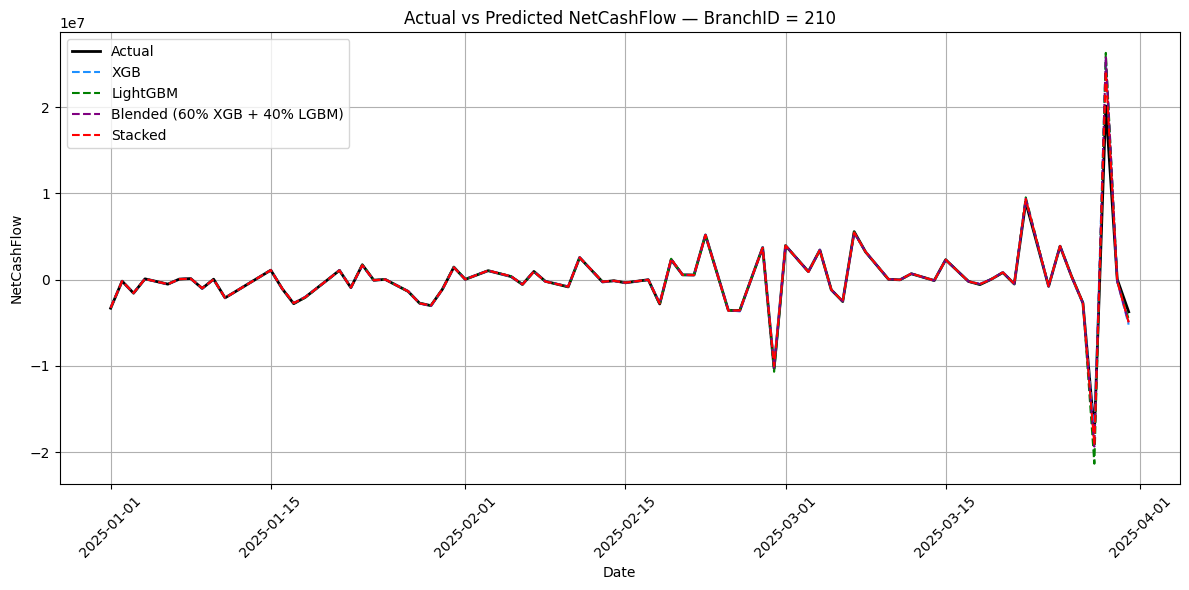

In [57]:
# Load saved models and features
with open("xgb_best_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open("xgb_selected_features.pkl", "rb") as f:
    xgb_features = pickle.load(f)

with open("lgbm_best_model.pkl", "rb") as f:
    lgbm_model = pickle.load(f)

with open("lgbm_selected_features.pkl", "rb") as f:
    lgbm_features = pickle.load(f)

with open("stacked_meta_model.pkl", "rb") as f:
    meta_model = pickle.load(f)


# Ensure TXNDATE is datetime and reset index
test_df = test_df.copy()
test_df["TXNDATE"] = pd.to_datetime(test_df["TXNDATE"])
test_df = test_df.reset_index(drop=True)


# Prepare test sets
X_test_xgb = test_df[xgb_features]
X_test_lgb = test_df[lgbm_features]
y_test_series = pd.Series(y_test).reset_index(drop=True)


# Get predictions from base models
y_pred_xgb = pd.Series(xgb_model.predict(X_test_xgb)).reset_index(drop=True)
y_pred_lgb = pd.Series(lgbm_model.predict(X_test_lgb)).reset_index(drop=True)


# Blended prediction (60% XGB + 40% LGBM)
y_pred_blend = 0.6 * y_pred_xgb + 0.4 * y_pred_lgb


# Build meta features for stacked prediction
stacked_test = pd.DataFrame({
    "XGB_Pred": y_pred_xgb,
    "LGB_Pred": y_pred_lgb
})
stacked_test["Avg_Pred"] = (y_pred_xgb + y_pred_lgb) / 2
stacked_test["Diff_Pred"] = y_pred_xgb - y_pred_lgb
stacked_test["Ratio_Pred"] = y_pred_xgb / (y_pred_lgb + 1e-6)
stacked_test["Min_Pred"] = np.minimum(y_pred_xgb, y_pred_lgb)
stacked_test["Max_Pred"] = np.maximum(y_pred_xgb, y_pred_lgb)


# Final stacked prediction
y_pred_stack = pd.Series(meta_model.predict(stacked_test)).reset_index(drop=True)


# Merge predictions into test_df
test_df["Actual"] = y_test_series
test_df["XGB_Pred"] = y_pred_xgb
test_df["LGB_Pred"] = y_pred_lgb
test_df["Blended_Pred"] = y_pred_blend
test_df["Stacked_Pred"] = y_pred_stack


# Filter for specific BranchID and plot
branch_id = 210  
branch_df = test_df[test_df["BRANCHID"] == branch_id].sort_values("TXNDATE")

plt.figure(figsize=(12,6))
plt.plot(branch_df["TXNDATE"], branch_df["Actual"], label="Actual", color="black", linewidth=2)
plt.plot(branch_df["TXNDATE"], branch_df["XGB_Pred"], label="XGB", color="dodgerblue", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["LGB_Pred"], label="LightGBM", color="green", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Blended_Pred"], label="Blended (60% XGB + 40% LGBM)", color="purple", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Stacked_Pred"], label="Stacked", color="red", linestyle="--")

plt.title(f"Actual vs Predicted NetCashFlow — BranchID = {branch_id}")
plt.xlabel("Date")
plt.ylabel("NetCashFlow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ML Prediction for a given date range

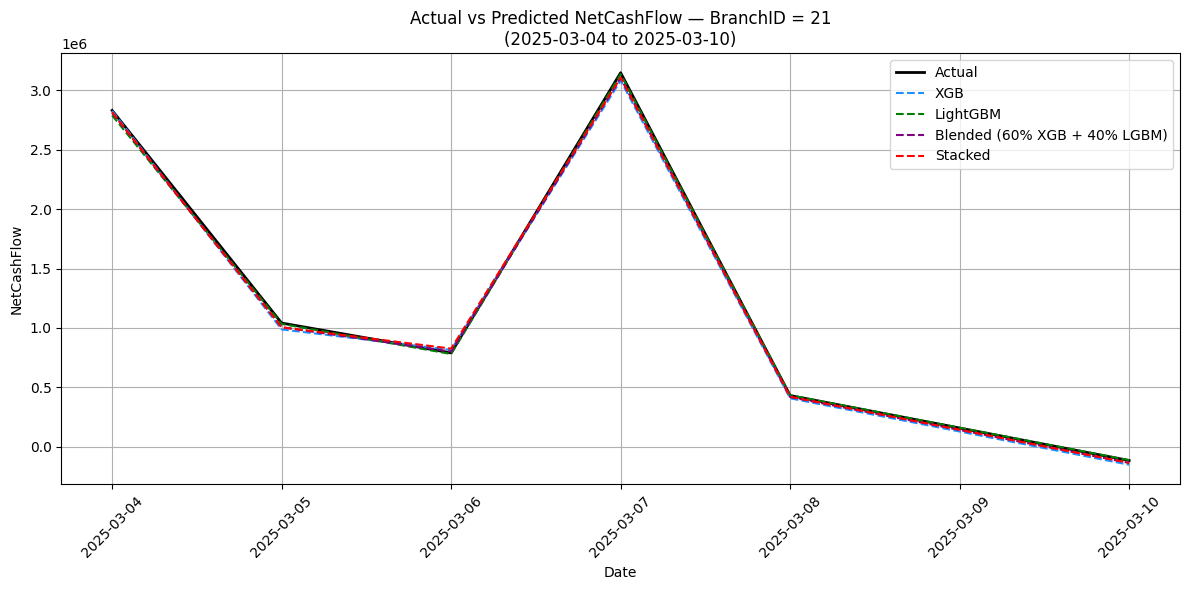

In [58]:
# Load saved models and features
with open("xgb_best_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open("xgb_selected_features.pkl", "rb") as f:
    xgb_features = pickle.load(f)

with open("lgbm_best_model.pkl", "rb") as f:
    lgbm_model = pickle.load(f)

with open("lgbm_selected_features.pkl", "rb") as f:
    lgbm_features = pickle.load(f)

with open("stacked_meta_model.pkl", "rb") as f:
    meta_model = pickle.load(f)


# Ensure TXNDATE is datetime and reset index
test_df = test_df.copy()
test_df["TXNDATE"] = pd.to_datetime(test_df["TXNDATE"])
test_df = test_df.reset_index(drop=True)


# Prepare test sets
X_test_xgb = test_df[xgb_features]
X_test_lgb = test_df[lgbm_features]
y_test_series = pd.Series(y_test).reset_index(drop=True)


# Get predictions from base models
y_pred_xgb = pd.Series(xgb_model.predict(X_test_xgb)).reset_index(drop=True)
y_pred_lgb = pd.Series(lgbm_model.predict(X_test_lgb)).reset_index(drop=True)


# Blended prediction (60% XGB + 40% LGBM)
y_pred_blend = 0.6 * y_pred_xgb + 0.4 * y_pred_lgb


# Build meta features for stacked prediction
stacked_test = pd.DataFrame({
    "XGB_Pred": y_pred_xgb,
    "LGB_Pred": y_pred_lgb
})
stacked_test["Avg_Pred"] = (y_pred_xgb + y_pred_lgb) / 2
stacked_test["Diff_Pred"] = y_pred_xgb - y_pred_lgb
stacked_test["Ratio_Pred"] = y_pred_xgb / (y_pred_lgb + 1e-6)
stacked_test["Min_Pred"] = np.minimum(y_pred_xgb, y_pred_lgb)
stacked_test["Max_Pred"] = np.maximum(y_pred_xgb, y_pred_lgb)


# Final stacked prediction
y_pred_stack = pd.Series(meta_model.predict(stacked_test)).reset_index(drop=True)


# Merge predictions into test_df
test_df["Actual"] = y_test_series
test_df["XGB_Pred"] = y_pred_xgb
test_df["LGB_Pred"] = y_pred_lgb
test_df["Blended_Pred"] = y_pred_blend
test_df["Stacked_Pred"] = y_pred_stack


# Filter for specific BranchID and Date Range, then plot
branch_id = 21   
start_date = "2025-03-04"   
end_date   = "2025-03-10"  

branch_df = test_df[test_df["BRANCHID"] == branch_id].copy()
branch_df = branch_df.sort_values("TXNDATE")

# Apply date filter
mask = (branch_df["TXNDATE"] >= pd.to_datetime(start_date)) & (branch_df["TXNDATE"] <= pd.to_datetime(end_date))
branch_df = branch_df.loc[mask]

# Plot
plt.figure(figsize=(12,6))
plt.plot(branch_df["TXNDATE"], branch_df["Actual"], label="Actual", color="black", linewidth=2)
plt.plot(branch_df["TXNDATE"], branch_df["XGB_Pred"], label="XGB", color="dodgerblue", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["LGB_Pred"], label="LightGBM", color="green", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Blended_Pred"], label="Blended (60% XGB + 40% LGBM)", color="purple", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Stacked_Pred"], label="Stacked", color="red", linestyle="--")

plt.title(f"Actual vs Predicted NetCashFlow — BranchID = {branch_id}\n({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("NetCashFlow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

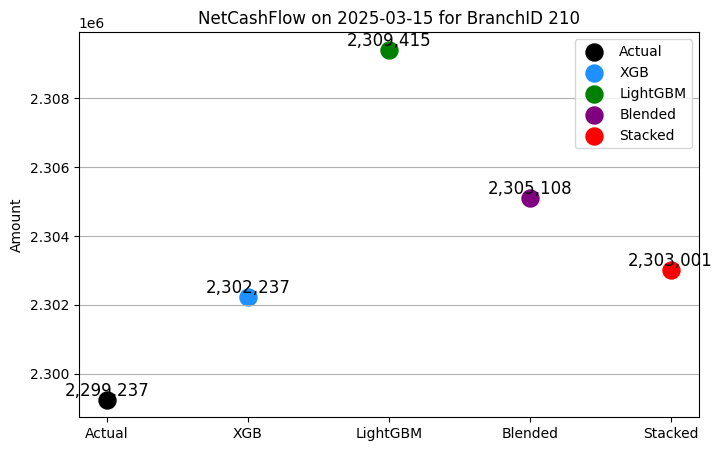

In [59]:
# Input: specify the date and branch you want to inspect
query_date = pd.to_datetime("2025-03-15")  
branch_id = 210 

# Filter test_df for this branch and date
subset = test_df[
    (test_df["BRANCHID"] == branch_id) & 
    (test_df["TXNDATE"] == query_date)
]

if subset.empty:
    print(f"No data found for BranchID={branch_id} on {query_date.date()}")
else:
    # Extract actual and predicted values (all should be scalars)
    actual = subset["Actual"].values[0]
    xgb_pred = subset["XGB_Pred"].values[0]
    lgb_pred = subset["LGB_Pred"].values[0]
    blended_pred = subset["Blended_Pred"].values[0]
    stacked_pred = subset["Stacked_Pred"].values[0]

    # Prepare plot data
    labels = ["Actual", "XGB", "LightGBM", "Blended", "Stacked"]
    values = [actual, xgb_pred, lgb_pred, blended_pred, stacked_pred]
    colors = ["black", "dodgerblue", "green", "purple", "red"]

    plt.figure(figsize=(8,5))
    # Plot each point individually to assign legend labels
    for label, val, color in zip(labels, values, colors):
        plt.scatter(label, val, color=color, s=150, label=label)
        plt.text(label, val, f"{val:,.0f}", ha='center', va='bottom', fontsize=12)

    plt.title(f"NetCashFlow on {query_date.date()} for BranchID {branch_id}")
    plt.ylabel("Amount")
    plt.grid(axis='y')
    plt.legend()
    plt.show()


### Predicted values in a table

In [60]:
# Input: specify date range and branch
start_date = pd.to_datetime("2025-03-10")  
end_date = pd.to_datetime("2025-03-15")    
branch_id = 210                            


# Filter DataFrame for given branch and date range
subset = test_df[
    (test_df["BRANCHID"] == branch_id) & 
    (test_df["TXNDATE"] >= start_date) & 
    (test_df["TXNDATE"] <= end_date)
].copy()


# Check if data exists and display table
if subset.empty:
    print(f"No data found for BranchID={branch_id} between {start_date.date()} and {end_date.date()}")
else:
    # Select and rename relevant columns
    display_df = subset[[
        "TXNDATE", "Actual", "XGB_Pred", "LGB_Pred", "Blended_Pred", "Stacked_Pred"
    ]].rename(columns={
        "TXNDATE": "Date",
        "Actual": "Actual",
        "XGB_Pred": "XGBoost",
        "LGB_Pred": "LightGBM",
        "Blended_Pred": "Blended",
        "Stacked_Pred": "Stacked"
    })

    # Optional: Format large numbers for display
    display_df = display_df.sort_values("Date")
    display_df["Date"] = display_df["Date"].dt.date  # clean date format

    # Format numeric columns
    formatted_df = display_df.copy()
    for col in ["Actual", "XGBoost", "LightGBM", "Blended", "Stacked"]:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:,.0f}")

    # Show table
    import IPython
    from IPython.display import display
    display(formatted_df)


,Date,Actual,XGBoost,LightGBM,Blended,Stacked
12592,2025-03-10,"32,140","51,684","43,350","48,351","43,363"
12593,2025-03-11,"-29,720","-23,062","-54,100","-35,477","-26,405"
12594,2025-03-12,"673,745","687,244","686,971","687,135","700,664"
12595,2025-03-14,"-110,520","-117,392","-120,963","-118,821","-109,178"
12596,2025-03-15,"2,299,237","2,302,237","2,309,415","2,305,108","2,303,001"


# Part 02

# Deep Learning

### Check Data Types and Convert

In [61]:
# Set random seed for reproducibility

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [62]:
df_step1 = df.copy()

# Convert TXNDATE to datetime
df_step1['TXNDATE'] = pd.to_datetime(df_step1['TXNDATE'], dayfirst=True)

# Convert categorical columns to 'category' dtype
categorical_cols = ['BRANCH', 'DISTRICT', 'PROVINCE', 'CODE']
for col in categorical_cols:
    df_step1[col] = df_step1[col].astype('category')

print(df_step1.dtypes)

TXNDATE                    datetime64[ns]
BRANCHID                            int64
CODE                             category
BRANCH                           category
DISTRICT                         category
                                ...      
IsFirst5Days                        int64
IsLast5Days                         int64
NCPI_Index                        float64
NCPI-Headline_Inflation           float64
NCPI-Core_Inflation               float64
Length: 88, dtype: object


### Missing values

In [63]:
df_step1 = df_step1.dropna(subset=rolling_lag_cols).reset_index(drop=True)

In [64]:
df_step1.shape

(165707, 88)

### Drop 'BRANCH' column

In [65]:
# Create the mapping dictionary once before dropping the column
branch_mapping = df_step1[['BRANCHID', 'BRANCH']].drop_duplicates().set_index('BRANCHID')['BRANCH'].to_dict()

# Drop the BRANCH column before modeling
df_step2 = df_step1.drop(columns=['BRANCH'])

In [66]:
df_step2.head()

,TXNDATE,BRANCHID,CODE,DISTRICT,PROVINCE,LATITUDE,LONGITUDE,CUSTOMER,TOTALTXNAMOUNT,TOTALCREDITAMOUNT,...,Credit_ZScore,IsMonthStart,IsMonthEnd,DayOfMonth,DaysInMonth,IsFirst5Days,IsLast5Days,NCPI_Index,NCPI-Headline_Inflation,NCPI-Core_Inflation
0,2022-05-09,1,1,COLOMBO,WESTERN,6.902243,79.86391,40,32142639.71,8595271.00,...,0.022379,0,0,9,31,0,0,166.3,45.3,37.7
1,2022-05-12,1,1,COLOMBO,WESTERN,6.902243,79.86391,28,9311210.11,1376486.00,...,-1.963350,0,0,12,31,0,0,166.3,45.3,37.7
2,2022-05-13,1,1,COLOMBO,WESTERN,6.902243,79.86391,39,18262373.26,9810740.44,...,0.358672,0,0,13,31,0,0,166.3,45.3,37.7
3,2022-05-14,1,1,COLOMBO,WESTERN,6.902243,79.86391,9,9534600.00,134600.00,...,-1.802514,0,0,14,31,0,0,166.3,45.3,37.7
4,2022-05-17,1,1,COLOMBO,WESTERN,6.902243,79.86391,63,25113643.06,6210180.93,...,-0.151556,0,0,17,31,0,0,166.3,45.3,37.7


### Categorical Encoding and Binary conversion

In [67]:
# List of categorical columns to one-hot encode
cat_cols = ['DISTRICT', 'PROVINCE']

# For binary columns, convert to int 
binary_cols = ['IsWeekend', 'IsHoliday', 'IsNonWorkingDay', 'IsMonthStart', 'IsMonthEnd', 'IsFirst5Days', 'IsLast5Days']

# Convert binary columns to integer (0/1) type
for col in binary_cols:
    df_step2[col] = df_step2[col].astype(int)

# One-hot encode categorical columns with drop_first=True to avoid multicollinearity
df_encoded = pd.get_dummies(df_step2, columns=cat_cols, drop_first=True)

### Data Split

In [68]:
# Make sure TXNDATE is datetime
df_encoded["TXNDATE"] = pd.to_datetime(df_encoded["TXNDATE"], dayfirst=True)

# Sort by TXNDATE and BRANCHID
df_encoded = df_encoded.sort_values(["TXNDATE", "BRANCHID"]).reset_index(drop=True)

# Split date thresholds
train_end = pd.Timestamp("2024-12-31")
test_start = pd.Timestamp("2025-01-01")
test_end = pd.Timestamp("2025-03-31")

# Training data
train_df = df_encoded[df_encoded["TXNDATE"] <= train_end].copy()

# Test data
test_df = df_encoded[
    (df_encoded["TXNDATE"] >= test_start) &
    (df_encoded["TXNDATE"] <= test_end)
].copy()

print("Train dates:", train_df["TXNDATE"].min(), "to", train_df["TXNDATE"].max())
print("Test dates:", test_df["TXNDATE"].min(), "to", test_df["TXNDATE"].max())
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Columns to drop from inputs
drop_cols = [
    "NetCashFlow_Per_Customer",
    "TOTALTXNAMOUNT"
]

# Drop from both train and test
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# Define target column
target_col = "NetCashFlow"

# Prepare feature and target sets
# BRANCHID (embedding) and TXNDATE (sequencing)
X_train_full = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test_full = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

print("X_train columns:", X_train_full.columns.tolist())
print("X_train shape:", X_train_full.shape)
print("y_train shape:", y_train.shape)

Train dates: 2022-05-07 00:00:00 to 2024-12-31 00:00:00
Test dates: 2025-01-01 00:00:00 to 2025-03-31 00:00:00
Train shape: (150104, 117)
Test shape: (15603, 117)
X_train columns: ['TXNDATE', 'BRANCHID', 'CODE', 'LATITUDE', 'LONGITUDE', 'CUSTOMER', 'TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'DayOfWeek', 'IsWeekend', 'Month', 'Year', 'IsHoliday', 'IsNonWorkingDay', 'Lag1_Credit', 'Lag1_Debit', 'Lag1_Customers', 'Lag2_Credit', 'Lag2_Debit', 'Lag2_Customers', 'Lag3_Credit', 'Lag3_Debit', 'Lag3_Customers', 'Lag7_Credit', 'Lag7_Debit', 'Lag7_Customers', 'Lag14_Credit', 'Lag14_Debit', 'Lag14_Customers', 'Rolling7_DebitMean', 'Rolling7_DebitStd', 'Rolling7_CustomersMean', 'Rolling7_CustomersStd', 'Rolling7_CreditMean', 'Rolling7_CreditStd', 'Rolling3_CreditMean', 'Rolling3_DebitMean', 'Rolling3_CustomersMean', 'Rolling3_CustomersStd', 'Rolling3_CreditStd', 'Rolling3_DebitStd', 'Rolling30_CreditMean', 'Rolling30_DebitMean', 'Rolling30_CustomersMean', 'Rolling30_CustomersStd', 'Rolling30_CreditSt

### Correlation Check

In [69]:
# Reset index
X_train_full_reset = X_train_full.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Combine to a single DataFrame
train_merged = pd.concat([X_train_full_reset, y_train_reset], axis=1)

# Confirm columns
print(train_merged.columns)

Index(['TXNDATE', 'BRANCHID', 'CODE', 'LATITUDE', 'LONGITUDE', 'CUSTOMER',
       'TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'DayOfWeek', 'IsWeekend',
       ...
       'DISTRICT_VAVUNIYA', 'PROVINCE_EASTERN', 'PROVINCE_NORTH CENTRAL',
       'PROVINCE_NORTH WESTERN', 'PROVINCE_NORTHERN', 'PROVINCE_SABARAGAMUWA',
       'PROVINCE_SOUTHERN', 'PROVINCE_UVA', 'PROVINCE_WESTERN', 'NetCashFlow'],
      dtype='object', length=115)


In [70]:
train_merged["TXNDATE"] = pd.to_datetime(train_merged["TXNDATE"])
train_merged = train_merged.sort_values(["BRANCHID", "TXNDATE"]).reset_index(drop=True)

In [71]:
# Extract numeric columns to feed LSTM
cols_to_exclude = ["TXNDATE", "BRANCHID", "NetCashFlow"]
numeric_cols = [c for c in train_merged.columns if c not in cols_to_exclude]
print("Numeric features for LSTM:", numeric_cols)

Numeric features for LSTM: ['CODE', 'LATITUDE', 'LONGITUDE', 'CUSTOMER', 'TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'DayOfWeek', 'IsWeekend', 'Month', 'Year', 'IsHoliday', 'IsNonWorkingDay', 'Lag1_Credit', 'Lag1_Debit', 'Lag1_Customers', 'Lag2_Credit', 'Lag2_Debit', 'Lag2_Customers', 'Lag3_Credit', 'Lag3_Debit', 'Lag3_Customers', 'Lag7_Credit', 'Lag7_Debit', 'Lag7_Customers', 'Lag14_Credit', 'Lag14_Debit', 'Lag14_Customers', 'Rolling7_DebitMean', 'Rolling7_DebitStd', 'Rolling7_CustomersMean', 'Rolling7_CustomersStd', 'Rolling7_CreditMean', 'Rolling7_CreditStd', 'Rolling3_CreditMean', 'Rolling3_DebitMean', 'Rolling3_CustomersMean', 'Rolling3_CustomersStd', 'Rolling3_CreditStd', 'Rolling3_DebitStd', 'Rolling30_CreditMean', 'Rolling30_DebitMean', 'Rolling30_CustomersMean', 'Rolling30_CustomersStd', 'Rolling30_CreditStd', 'Rolling30_DebitStd', 'Lag1_Credit_vs_Mean3', 'Lag1_Credit_Ratio_Mean3', 'Lag1_Credit_ZScore3', 'Lag1_Credit_vs_Mean7', 'Lag1_Credit_Ratio_Mean7', 'Lag1_Credit_ZScore7', 'L

# LSTM

### Tunned parameters from Randomised Search

In [72]:
# Load the saved hyperparameters
with open("p2.json", "r") as f:
    saved_hps = json.load(f)

# Print the hyperparameters nicely
print("Saved Hyperparameters:")
for key, value in saved_hps.items():
    print(f"{key}: {value}")

Saved Hyperparameters:
embed_dim: 32
lstm_units: 96
dropout: 0.30000000000000004
dense_units: 80
learning_rate: 0.0035871410103749386


### Common Sequence

In [73]:
# Reproducibility Setup
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Sequence Configuration
SEQ_LEN = 60


# Feature Selection
exclude_cols = ["TXNDATE", "BRANCHID"]
numeric_cols = [col for col in X_train_full.columns if col not in exclude_cols]

TOP_N_FEATURES = 50
X_temp = X_train_full[numeric_cols].select_dtypes(include=['int64', 'float64', 'bool']).copy()
y_temp = y_train

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=SEED)
xgb_model.fit(X_temp, y_temp)

feature_importances = pd.Series(xgb_model.feature_importances_, index=X_temp.columns)
top_features = feature_importances.nlargest(TOP_N_FEATURES).index.tolist()

print(f"Selected Top {TOP_N_FEATURES} Features:\n", top_features)


# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[top_features])
X_test_scaled = scaler.transform(X_test_full[top_features])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=top_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=top_features)


# Sequence Generator
def create_lstm_sequences(X_df, y_series, branch_series, window):
    X_numeric_seq, X_branch_seq, y_seq = [], [], []

    for i in range(window, len(X_df)):
        X_numeric_seq.append(X_df.iloc[i - window:i].values)
        X_branch_seq.append(branch_series.iloc[i])
        y_seq.append(y_series.iloc[i])

    return (
        np.array(X_numeric_seq, dtype=np.float32),
        np.array(X_branch_seq, dtype=np.int32).reshape(-1, 1),
        np.array(y_seq, dtype=np.float32)
    )


# Create Sequences
n_branches = int(X_train_full["BRANCHID"].max()) + 1

X_num_seq_train, X_branch_seq_train, y_seq_train = create_lstm_sequences(
    X_train_scaled_df.reset_index(drop=True),
    y_train.reset_index(drop=True),
    X_train_full["BRANCHID"].reset_index(drop=True),
    window=SEQ_LEN
)

X_num_seq_test, X_branch_seq_test, y_seq_test = create_lstm_sequences(
    X_test_scaled_df.reset_index(drop=True),
    pd.Series(y_test).reset_index(drop=True),
    X_test_full["BRANCHID"].reset_index(drop=True),
    window=SEQ_LEN
)

Selected Top 50 Features:
 ['TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'Debit_to_Credit_Ratio', 'Lag1_Customers_Ratio_Mean3', 'Delta_Debit', 'Debit_ZScore', 'CashOut_Per_Customer', 'CashIn_Per_Customer', 'Rolling30_CustomersStd', 'Lag1_Debit_Ratio_Mean7', 'Rolling3_DebitStd', 'Delta_Credit', 'Lag1_Credit_vs_Mean3', 'Lag3_Credit', 'Lag2_Customers', 'Lag7_Credit', 'Delta_Customers', 'Lag7_Customers', 'CUSTOMER', 'Lag14_Debit', 'Credit_ZScore', 'Lag3_Debit', 'Lag3_Customers', 'Lag1_Customers_ZScore7', 'LATITUDE', 'LONGITUDE', 'Lag1_Credit', 'Rolling30_CreditStd', 'Rolling3_CreditStd', 'Rolling3_CustomersStd', 'Rolling30_CustomersMean', 'Lag1_Debit_vs_Mean3', 'Rolling30_CreditMean', 'Rolling3_DebitMean', 'Lag14_Credit', 'Lag2_Debit', 'Lag1_Debit_ZScore7', 'Rolling7_CustomersStd', 'Lag1_Debit', 'Rolling7_DebitMean', 'Rolling30_DebitStd', 'Lag7_Debit', 'Lag1_Credit_vs_Mean7', 'Lag14_Customers', 'NCPI_Index', 'Rolling7_CreditMean', 'IsWeekend', 'IsHoliday', 'IsNonWorkingDay', 'Lag1_Customers']


### Optimal Model - LSTM

### Save the optimal model

### Loading the saved optimal LSTM model

In [74]:
# Re-register the custom layer so Keras can find it
@register_keras_serializable()
class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.W = Dense(1)

    def call(self, inputs):
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        return tf.reduce_sum(context_vector, axis=1)

    def get_config(self):
        return super(CustomAttention, self).get_config()

# Load the model for later use
lstm_model = load_model("best_lstm_model.keras", custom_objects={"CustomAttention": CustomAttention})

# Predict on test set
y_pred_lstm = lstm_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()

mae_test = mean_absolute_error(y_seq_test, y_pred_lstm)
rmse_test = np.sqrt(mean_squared_error(y_seq_test, y_pred_lstm))

print(f"\n Final Test MAE: {mae_test:,.2f}")
print(f" Final Test RMSE: {rmse_test:,.2f}")


C:\Users\anjal\Dissertation\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



486/486 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step

 Final Test MAE: 1,615,675.50
 Final Test RMSE: 3,822,476.79


# Temporal Convolutional Network (TCN)

### Loading the best parameters

In [75]:
# Load and print the JSON file
json_file_path = "best_tcn_hyperparams.json"

with open(json_file_path, "r") as f:
    best_params = json.load(f)

# Print in a nicely formatted way
print("Best TCN Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Best TCN Hyperparameters:
embed_dim: 16
nb_filters: 64
kernel_size: 2
dropout_rate: 0.30000000000000004
dense_units: 32


### Common sequence

In [76]:
# Initial Setup
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
SEQ_LEN = 60

# Feature Selection
exclude_cols = ["TXNDATE", "BRANCHID"]
numeric_cols = [col for col in X_train_full.columns if col not in exclude_cols]

TOP_N_FEATURES = 50
X_temp = X_train_full[numeric_cols].select_dtypes(include=['int64', 'float64', 'bool']).copy()
y_temp = y_train

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=SEED)
xgb_model.fit(X_temp, y_temp)

importances = xgb_model.feature_importances_
feat_imp = pd.Series(importances, index=X_temp.columns).sort_values(ascending=False)
top_features = feat_imp.head(TOP_N_FEATURES).index.tolist()

print(f"Selected Top {TOP_N_FEATURES} Features:\n", top_features)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[top_features])
X_test_scaled = scaler.transform(X_test_full[top_features])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=top_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=top_features)

# Sequence Creation
def create_sequences(X_df, y_series, branch_series, window):
    X_numeric_seq, X_branch_seq, y_seq = [], [], []
    for idx in range(window, len(X_df)):
        X_numeric_seq.append(X_df.iloc[idx - window:idx].values)
        X_branch_seq.append(branch_series.iloc[idx])
        y_seq.append(y_series.iloc[idx])
    return (
        np.array(X_numeric_seq).astype(np.float32),
        np.array(X_branch_seq).astype(np.int32).reshape(-1, 1),
        np.array(y_seq).astype(np.float32)
    )

n_branches = int(X_train_full["BRANCHID"].max()) + 1

X_num_seq, X_branch_seq, y_seq = create_sequences(
    X_train_scaled.reset_index(drop=True),
    y_train.reset_index(drop=True),
    X_train_full["BRANCHID"].reset_index(drop=True),
    window=SEQ_LEN
)

X_num_seq_test, X_branch_seq_test, y_seq_test = create_sequences(
    X_test_scaled.reset_index(drop=True),
    pd.Series(y_test).reset_index(drop=True),
    X_test_full["BRANCHID"].reset_index(drop=True),
    window=SEQ_LEN
)

X_num_train, X_num_test, X_branch_train, X_branch_test, y_train_new, y_test = train_test_split(
    X_num_seq, X_branch_seq, y_seq, test_size=0.2, shuffle=False
)

input_shape_num = X_num_seq.shape[1:]
input_shape_branch = X_branch_seq.shape[1:]
vocab_size = int(np.max(X_branch_seq)) + 1

Selected Top 50 Features:
 ['TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'Debit_to_Credit_Ratio', 'Lag1_Customers_Ratio_Mean3', 'Delta_Debit', 'Debit_ZScore', 'CashOut_Per_Customer', 'CashIn_Per_Customer', 'Rolling30_CustomersStd', 'Lag1_Debit_Ratio_Mean7', 'Rolling3_DebitStd', 'Delta_Credit', 'Lag1_Credit_vs_Mean3', 'Lag3_Credit', 'Lag2_Customers', 'Lag7_Credit', 'Delta_Customers', 'Lag7_Customers', 'CUSTOMER', 'Lag14_Debit', 'Credit_ZScore', 'Lag3_Debit', 'Lag3_Customers', 'Lag1_Customers_ZScore7', 'LATITUDE', 'LONGITUDE', 'Lag1_Credit', 'Rolling30_CreditStd', 'Rolling3_CreditStd', 'Rolling3_CustomersStd', 'Rolling30_CustomersMean', 'Lag1_Debit_vs_Mean3', 'Rolling30_CreditMean', 'Rolling3_DebitMean', 'Lag14_Credit', 'Lag2_Debit', 'Lag1_Debit_ZScore7', 'Rolling7_CustomersStd', 'Lag1_Debit', 'Rolling7_DebitMean', 'Rolling30_DebitStd', 'Lag7_Debit', 'Lag1_Credit_vs_Mean7', 'Lag14_Customers', 'NCPI_Index', 'Rolling7_CreditMean', 'Rolling30_DebitMean', 'Rolling7_CreditStd', 'Rolling3_CreditMe

### Optimised TCN

### Save the best model

### Loading the saved TCN model

In [77]:
# Load the model
tcn_model = tf.keras.models.load_model("tcn_best_model.keras")

print(" Model loaded successfully")

# Predict on test data
y_pred_tcn = tcn_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()

mae = mean_absolute_error(y_seq_test, y_pred_tcn)
rmse = np.sqrt(mean_squared_error(y_seq_test, y_pred_tcn))


print(f"Test MAE: {mae:,.2f}")
print(f"Test RMSE: {rmse:,.2f}")

 Model loaded successfully
486/486 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step
Test MAE: 1,658,053.50
Test RMSE: 3,856,614.71


## Model Blending

### Search Best Blending Weights

### Optimal Blending model

### Saving the optimal blending model

In [78]:
# Load blended model
with open("dl_best_blend_model.pkl", "rb") as f:
    blend_package = pickle.load(f)

lstm_model_loaded = blend_package["lstm_model"]
tcn_model_loaded = blend_package["tcn_model"]
best_weight_loaded = blend_package["best_weight"]

print(f" Loaded best weight: {best_weight_loaded:.2f}")

# Predict using loaded models
y_pred_lstm_loaded = lstm_model_loaded.predict([X_num_seq_test, X_branch_seq_test]).flatten()
y_pred_tcn_loaded = tcn_model_loaded.predict([X_num_seq_test, X_branch_seq_test]).flatten()

# Blend predictions
y_pred_blend = best_weight_loaded * y_pred_lstm_loaded + (1 - best_weight_loaded) * y_pred_tcn_loaded

# Assuming y_seq_test is your true test targets
mae_blend = mean_absolute_error(y_seq_test, y_pred_blend)
rmse_blend = np.sqrt(mean_squared_error(y_seq_test, y_pred_blend))
r2_blend = r2_score(y_seq_test, y_pred_blend)

print(f"Blended Model Test MAE: {mae_blend:,.2f}")
print(f"Blended Model Test RMSE: {rmse_blend:,.2f}")
print(f"Blended Model Test R²: {r2_blend:.4f}")

C:\Users\anjal\Dissertation\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


 Loaded best weight: 0.90
486/486 ━━━━━━━━━━━━━━━━━━━━ 53s 107ms/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step
Blended Model Test MAE: 1,623,555.47
Blended Model Test RMSE: 3,830,167.53
Blended Model Test R²: 0.0462


## Model Stacking

### Get validation predictions from base models

### Get test predictions for final stacking

### Improving Ridge stacker

#### Generate OOF predictions and train Ridge stacker

#### Build Meta Features, Train Ridge & Predict on Test Set

### Enrich Meta Features

### optimal XGBoost meta-model

### Save the Optimal Stack model

### Making the sequences

In [79]:
# Initial Setup
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
SEQ_LEN = 60

# Feature Selection
exclude_cols = ["TXNDATE", "BRANCHID"]
numeric_cols = [col for col in X_train_full.columns if col not in exclude_cols]

TOP_N_FEATURES = 50
X_temp = X_train_full[numeric_cols].select_dtypes(include=['int64', 'float64', 'bool']).copy()
y_temp = y_train

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=SEED)
xgb_model.fit(X_temp, y_temp)

importances = xgb_model.feature_importances_
feat_imp = pd.Series(importances, index=X_temp.columns).sort_values(ascending=False)
top_features = feat_imp.head(TOP_N_FEATURES).index.tolist()

print(f"Selected Top {TOP_N_FEATURES} Features:\n", top_features)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[top_features])
X_test_scaled = scaler.transform(X_test_full[top_features])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=top_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=top_features)

# Sequence Creation
def create_sequences(X_df, y_series, branch_series, window):
    X_numeric_seq, X_branch_seq, y_seq = [], [], []
    for idx in range(window, len(X_df)):
        X_numeric_seq.append(X_df.iloc[idx - window:idx].values)
        X_branch_seq.append(branch_series.iloc[idx])
        y_seq.append(y_series.iloc[idx])
    return (
        np.array(X_numeric_seq).astype(np.float32),
        np.array(X_branch_seq).astype(np.int32).reshape(-1, 1),
        np.array(y_seq).astype(np.float32)
    )

n_branches = int(X_train_full["BRANCHID"].max()) + 1

X_num_seq, X_branch_seq, y_seq = create_sequences(
    X_train_scaled.reset_index(drop=True),
    y_train.reset_index(drop=True),
    X_train_full["BRANCHID"].reset_index(drop=True),
    window=SEQ_LEN
)

X_num_seq_test, X_branch_seq_test, y_seq_test = create_sequences(
    X_test_scaled.reset_index(drop=True),
    pd.Series(y_test).reset_index(drop=True),
    X_test_full["BRANCHID"].reset_index(drop=True),
    window=SEQ_LEN
)

X_num_train, X_num_test, X_branch_train, X_branch_test, y_train_new, y_test = train_test_split(
    X_num_seq, X_branch_seq, y_seq, test_size=0.2, shuffle=False
)

input_shape_num = X_num_seq.shape[1:]
input_shape_branch = X_branch_seq.shape[1:]
vocab_size = int(np.max(X_branch_seq)) + 1

Selected Top 50 Features:
 ['TOTALCREDITAMOUNT', 'TOTALDEBITAMOUNT', 'Debit_to_Credit_Ratio', 'Lag1_Customers_Ratio_Mean3', 'Delta_Debit', 'Debit_ZScore', 'CashOut_Per_Customer', 'CashIn_Per_Customer', 'Rolling30_CustomersStd', 'Lag1_Debit_Ratio_Mean7', 'Rolling3_DebitStd', 'Delta_Credit', 'Lag1_Credit_vs_Mean3', 'Lag3_Credit', 'Lag2_Customers', 'Lag7_Credit', 'Delta_Customers', 'Lag7_Customers', 'CUSTOMER', 'Lag14_Debit', 'Credit_ZScore', 'Lag3_Debit', 'Lag3_Customers', 'Lag1_Customers_ZScore7', 'LATITUDE', 'LONGITUDE', 'Lag1_Credit', 'Rolling30_CreditStd', 'Rolling3_CreditStd', 'Rolling3_CustomersStd', 'Rolling30_CustomersMean', 'Lag1_Debit_vs_Mean3', 'Rolling30_CreditMean', 'Rolling3_DebitMean', 'Lag14_Credit', 'Lag2_Debit', 'Lag1_Debit_ZScore7', 'Rolling7_CustomersStd', 'Lag1_Debit', 'Rolling7_DebitMean', 'Rolling30_DebitStd', 'Lag7_Debit', 'Lag1_Credit_vs_Mean7', 'Lag14_Customers', 'NCPI_Index', 'Rolling7_CreditMean', 'Rolling30_DebitMean', 'Rolling7_CreditStd', 'Rolling3_CreditMe

#### Loading the optimal stack model

In [80]:
# Load the package
with open("dl_best_stack_model.pkl", "rb") as f:
    loaded_stack = pickle.load(f)

meta_model_loaded = loaded_stack["meta_model"]
X_meta_test_loaded = loaded_stack["X_meta_test"]
y_seq_test_loaded = loaded_stack["y_seq_test"]

# Predict with loaded meta model
y_meta_pred_loaded = meta_model_loaded.predict(X_meta_test_loaded)

# Evaluate
mae_loaded = mean_absolute_error(y_seq_test_loaded, y_meta_pred_loaded)
rmse_loaded = np.sqrt(mean_squared_error(y_seq_test_loaded, y_meta_pred_loaded))

print(f"Loaded Meta Model MAE: {mae_loaded:,.2f}")
print(f"Loaded Meta Model RMSE: {rmse_loaded:,.2f}")


Loaded Meta Model MAE: 1,633,965.38
Loaded Meta Model RMSE: 3,893,956.28


In [81]:
# Load all saved models

# LSTM & TCN models
with open("dl_best_blend_model.pkl", "rb") as f:
    blend_package = pickle.load(f)

lstm_model = blend_package["lstm_model"]
tcn_model = blend_package["tcn_model"]
best_blend_weight = blend_package["best_weight"]

# Stack model
with open("dl_best_stack_model.pkl", "rb") as f:
    stack_package = pickle.load(f)

stack_model = stack_package["meta_model"]


# Generate predictions

# Predict with LSTM & TCN
y_pred_lstm = lstm_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()
y_pred_tcn = tcn_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()

# Predict with Blend
y_pred_blend = best_blend_weight * y_pred_lstm + (1 - best_blend_weight) * y_pred_tcn

# Predict with Stack
X_meta_test_loaded = stack_package["X_meta_test"]  
y_pred_stack = stack_model.predict(X_meta_test_loaded)

# Ground truth
y_test = stack_package["y_seq_test"]


# Evaluation function
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


# Evaluate each model
results = {
    "Model": ["LSTM", "TCN", "Weighted Blend", "Stacked Model"],
    "RMSE": [],
    "MAE": [],
}

for preds in [y_pred_lstm, y_pred_tcn, y_pred_blend, y_pred_stack]:
    rmse, mae, r2 = evaluate_model(y_test, preds)
    results["RMSE"].append(f"{rmse:,.2f}")
    results["MAE"].append(f"{mae:,.2f}")
    


# Create summary table
results_df = pd.DataFrame(results)
print("\n Model Performance Summary:")
print(results_df.to_string(index=False))


C:\Users\anjal\Dissertation\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


486/486 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step

 Model Performance Summary:
         Model         RMSE          MAE
          LSTM 3,828,927.43 1,624,436.00
           TCN 3,856,614.71 1,658,053.50
Weighted Blend 3,830,167.53 1,623,555.47
 Stacked Model 3,893,956.28 1,633,965.38


C:\Users\anjal\Dissertation\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


486/486 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step


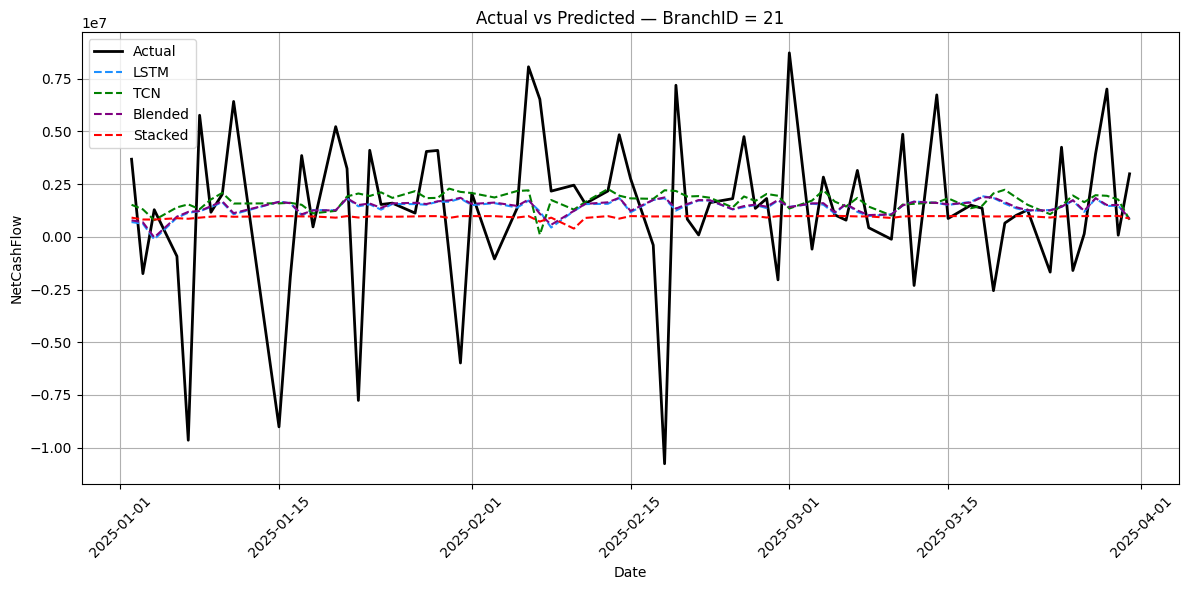

In [82]:
# Load saved blend model (contains LSTM, TCN, and best weight)
with open("dl_best_blend_model.pkl", "rb") as f:
    blend_package = pickle.load(f)

lstm_model = blend_package["lstm_model"]
tcn_model = blend_package["tcn_model"]
best_blend_weight = blend_package["best_weight"]

# Load saved stack model (contains meta_model, X_meta_test, and y_seq_test)
with open("dl_best_stack_model.pkl", "rb") as f:
    stack_package = pickle.load(f)

stack_model = stack_package["meta_model"]
X_meta_test_loaded = stack_package["X_meta_test"]
y_seq_test = stack_package["y_seq_test"]

# Ensure TXNDATE is datetime and reset index
test_df = test_df.copy()
test_df["TXNDATE"] = pd.to_datetime(test_df["TXNDATE"])
test_df = test_df.reset_index(drop=True)

# Predict with base models
y_pred_lstm = lstm_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()
y_pred_tcn = tcn_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()

# Weighted blended prediction
y_pred_blend = best_blend_weight * y_pred_lstm + (1 - best_blend_weight) * y_pred_tcn

# Stacked prediction
y_pred_stack = stack_model.predict(X_meta_test_loaded)

# Align test_df by dropping first SEQ_LEN rows (sequence window)
test_df_seq = test_df.iloc[SEQ_LEN:].copy().reset_index(drop=True)

# Confirm lengths match
assert len(test_df_seq) == len(y_seq_test), f"Mismatch: {len(test_df_seq)} vs {len(y_seq_test)}"

# Merge predictions into aligned DataFrame
test_df_seq["Actual"] = y_seq_test
test_df_seq["LSTM_Pred"] = y_pred_lstm
test_df_seq["TCN_Pred"] = y_pred_tcn
test_df_seq["Blended_Pred"] = y_pred_blend
test_df_seq["Stacked_Pred"] = y_pred_stack

# Plot for a specific BranchID
branch_id = 21 
branch_df = test_df_seq[test_df_seq["BRANCHID"] == branch_id].sort_values("TXNDATE")

plt.figure(figsize=(12,6))
plt.plot(branch_df["TXNDATE"], branch_df["Actual"], label="Actual", color="black", linewidth=2)
plt.plot(branch_df["TXNDATE"], branch_df["LSTM_Pred"], label="LSTM", color="dodgerblue", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["TCN_Pred"], label="TCN", color="green", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Blended_Pred"], label="Blended", color="purple", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Stacked_Pred"], label="Stacked", color="red", linestyle="--")

plt.title(f"Actual vs Predicted — BranchID = {branch_id}")
plt.xlabel("Date")
plt.ylabel("NetCashFlow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\anjal\Dissertation\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


486/486 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step


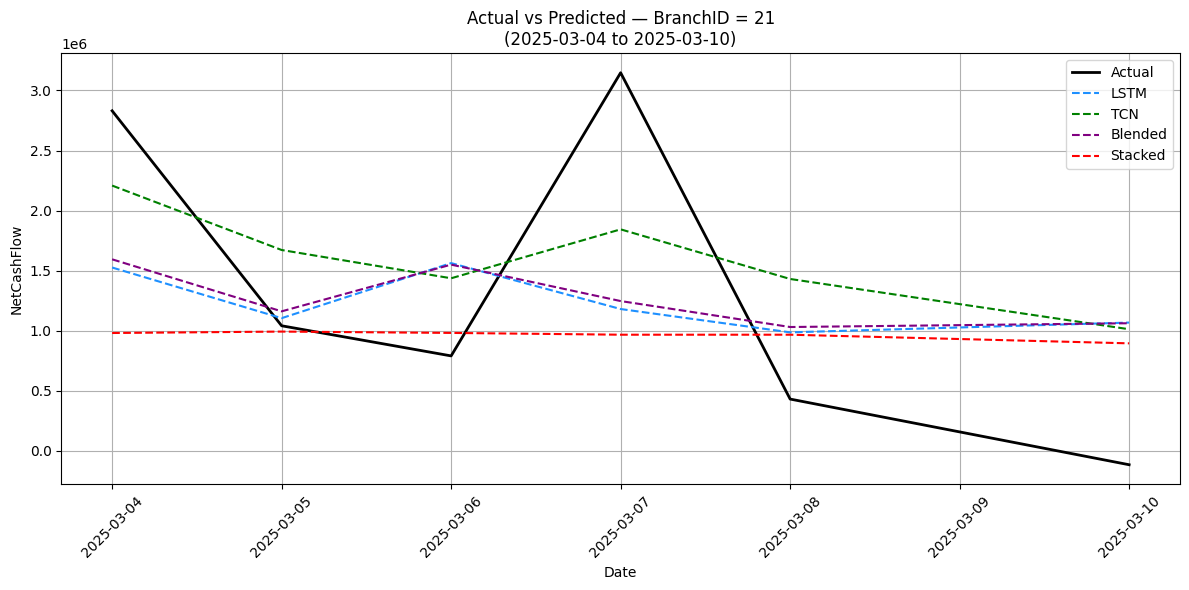

In [83]:
# Load saved blend model (contains LSTM, TCN, and best weight)
with open("dl_best_blend_model.pkl", "rb") as f:
    blend_package = pickle.load(f)

lstm_model = blend_package["lstm_model"]
tcn_model = blend_package["tcn_model"]
best_blend_weight = blend_package["best_weight"]

# Load saved stack model (contains meta_model, X_meta_test, and y_seq_test)
with open("dl_best_stack_model.pkl", "rb") as f:
    stack_package = pickle.load(f)

stack_model = stack_package["meta_model"]
X_meta_test_loaded = stack_package["X_meta_test"]
y_seq_test = stack_package["y_seq_test"]

# Ensure TXNDATE is datetime and reset index
test_df = test_df.copy()
test_df["TXNDATE"] = pd.to_datetime(test_df["TXNDATE"])
test_df = test_df.reset_index(drop=True)

# Predict with base models
y_pred_lstm = lstm_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()
y_pred_tcn = tcn_model.predict([X_num_seq_test, X_branch_seq_test]).flatten()

# Weighted blended prediction
y_pred_blend = best_blend_weight * y_pred_lstm + (1 - best_blend_weight) * y_pred_tcn

# Stacked prediction
y_pred_stack = stack_model.predict(X_meta_test_loaded)

# Align test_df by dropping first SEQ_LEN rows (sequence window)
test_df_seq = test_df.iloc[SEQ_LEN:].copy().reset_index(drop=True)

# Confirm lengths match
assert len(test_df_seq) == len(y_seq_test), f"Mismatch: {len(test_df_seq)} vs {len(y_seq_test)}"

# Merge predictions into aligned DataFrame
test_df_seq["Actual"] = y_seq_test
test_df_seq["LSTM_Pred"] = y_pred_lstm
test_df_seq["TCN_Pred"] = y_pred_tcn
test_df_seq["Blended_Pred"] = y_pred_blend
test_df_seq["Stacked_Pred"] = y_pred_stack

# Plot for a specific BranchID with date range
branch_id = 21  
start_date = "2025-03-04"   
end_date   = "2025-03-10"   

branch_df = test_df_seq[test_df_seq["BRANCHID"] == branch_id].copy()
branch_df = branch_df.sort_values("TXNDATE")

# Filter by date range
mask = (branch_df["TXNDATE"] >= pd.to_datetime(start_date)) & (branch_df["TXNDATE"] <= pd.to_datetime(end_date))
branch_df = branch_df.loc[mask]

# Plot
plt.figure(figsize=(12,6))
plt.plot(branch_df["TXNDATE"], branch_df["Actual"], label="Actual", color="black", linewidth=2)
plt.plot(branch_df["TXNDATE"], branch_df["LSTM_Pred"], label="LSTM", color="dodgerblue", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["TCN_Pred"], label="TCN", color="green", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Blended_Pred"], label="Blended", color="purple", linestyle="--")
plt.plot(branch_df["TXNDATE"], branch_df["Stacked_Pred"], label="Stacked", color="red", linestyle="--")

plt.title(f"Actual vs Predicted — BranchID = {branch_id}\n({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("NetCashFlow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


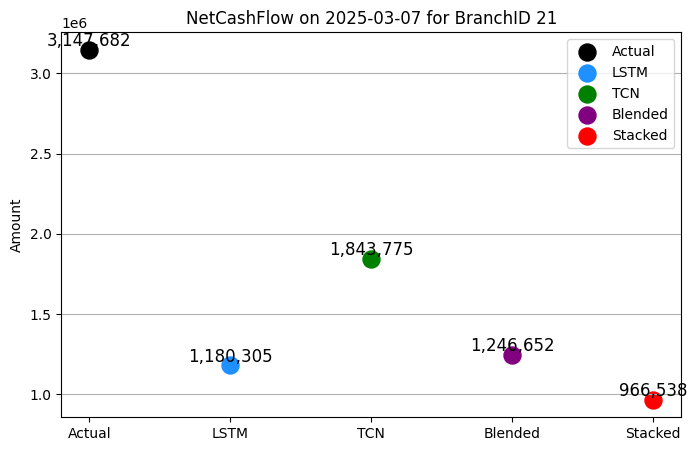

In [84]:
# Inputs: specify the date and branch to inspect
query_date = pd.to_datetime("2025-03-07")  
branch_id = 21 

# Filter aligned test DataFrame with sequence predictions
subset = test_df_seq[
    (test_df_seq["BRANCHID"] == branch_id) &
    (test_df_seq["TXNDATE"] == query_date)
]

if subset.empty:
    print(f"No data found for BranchID={branch_id} on {query_date.date()}")
else:
    # Extract scalar values (actual and predictions)
    actual = subset["Actual"].values[0]
    lstm_pred = subset["LSTM_Pred"].values[0]
    tcn_pred = subset["TCN_Pred"].values[0]
    blended_pred = subset["Blended_Pred"].values[0]
    stacked_pred = subset["Stacked_Pred"].values[0]

    # Prepare labels and values
    labels = ["Actual", "LSTM", "TCN", "Blended", "Stacked"]
    values = [actual, lstm_pred, tcn_pred, blended_pred, stacked_pred]
    colors = ["black", "dodgerblue", "green", "purple", "red"]

    plt.figure(figsize=(8, 5))

    # Plot points with legend and value annotations
    for label, val, color in zip(labels, values, colors):
        plt.scatter(label, val, color=color, s=150, label=label)
        plt.text(label, val, f"{val:,.0f}", ha='center', va='bottom', fontsize=12)

    plt.title(f"NetCashFlow on {query_date.date()} for BranchID {branch_id}")
    plt.ylabel("Amount")
    plt.grid(axis='y')
    plt.legend()
    plt.show()